# RNN Perform time series prediction 

In [1]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### load in and normalize the dataset
dataset = np.loadtxt('stock_prices.csv')

mms = MinMaxScaler()
dataset = mms.fit_transform(dataset.reshape(-1, 1))


Text(0, 0.5, 'normalized series value')

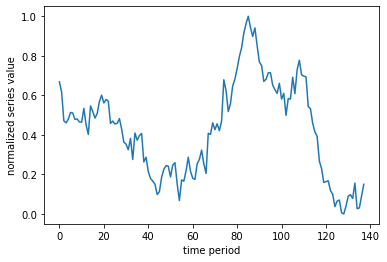

In [2]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

In [3]:
def window_transform_series(dataset, window_size):
    #Function to run a sliding window of window_size across the dataset
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size):
        a = dataset[i:(i+window_size)]
        dataX.append(a)
        dataY.append(dataset[i + window_size])
    return np.array(dataX), (np.array(dataY)).reshape(-1,1)

We can test your function on the list of odd numbers given below

In [4]:
odd_nums = np.array([1,3,5,7,9,11,13])
print(int(len(odd_nums)/2))

3


In [5]:
# run a window of size 2 over the odd number sequence and display the results
window_size = 3
X,y = window_transform_series(odd_nums,window_size)

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X)

print ('--- the associated output y will look like ----')
print (y)

print ('the shape of X is ' + str(np.shape(X)))
print ('the shape of y is ' + str(np.shape(y)))
print('the type of X is ' + str(type(X)))
print('the type of y is ' + str(type(y)))

--- the input X will look like ----
[[ 1  3  5]
 [ 3  5  7]
 [ 5  7  9]
 [ 7  9 11]]
--- the associated output y will look like ----
[[ 7]
 [ 9]
 [11]
 [13]]
the shape of X is (4, 3)
the shape of y is (4, 1)
the type of X is <class 'numpy.ndarray'>
the type of y is <class 'numpy.ndarray'>


In [6]:

def window_transform_series(series,window_size):
    # containers for input/output pairs
    #Function to run a sliding window of window_size across the dataset
    dataX, dataY = [], []
    for i in range(len(series)-window_size):
        a = series[i:(i+window_size)]
        dataX.append(a)
        dataY.append(series[i + window_size])
        
    # reshape each 
    X = np.asarray(dataX)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(dataY)
    y.shape = (len(y),1)
    
    return X,y

With this function in place apply it to the series in the Python cell below.  We use a window_size = 7 for these experiments.

In [7]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)
print(X.shape, y.shape)

(131, 7) (131, 1)


## Splitting into training and testing sets
Note how we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.  

In [8]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, stepsize, window size] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], 1, window_size)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], 1, window_size)))

In [9]:

# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)


# build an RNN to perform regression on our time series input/output data
model = Sequential()

#LSTM layer with 5 hidden units
model.add(LSTM(5, input_shape=(1, window_size)))

#Dropout added to avoid overfitting
model.add(Dropout(0.2))

#Fully connected layer with one output cell
model.add(Dense(1))

# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.gradient_descent_v2.SGD() #RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [10]:
# run your model!
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=0)

## Checking model performance



In [11]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In the next cell we compute training and testing errors using our trained model - you should be able to achieve at least

*training_accuracy* < 0.02

and 

*testing_accuracy* < 0.02

with your fully trained model.  

If either or both of your accuracies are larger than 0.02 re-train your model - increasing the number of epochs you take (a maximum of around 1,000 should do the job) and/or adjusting your batch_size.

In [12]:
# print out training and testing errors
training_accuracy = model.evaluate(X_train, y_train, verbose=0)
print('training accuracy = ' + str(training_accuracy))

testing_accuracy = model.evaluate(X_test, y_test, verbose=0)
print('testing accuracy = ' + str(testing_accuracy))

training accuracy = 0.01311069168150425
testing accuracy = 0.01921158656477928


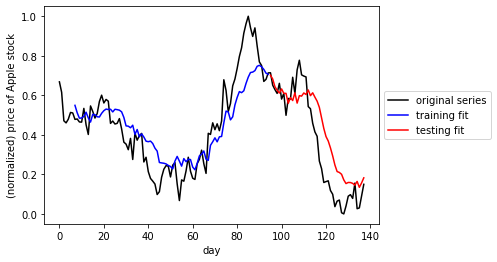

In [13]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()